In [1]:
# The program is set up to generate N neurons for the GPT-PINN. Once N neurons 
# has been achieved it is further trained to examine the largest loss 
# over all parameters once more. This is not needed for practical use.
# Set "train_final = False" (Line 60), if you wish to remove this behavior.

# Third-party and Standard Libraries
from datetime import datetime
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
print(f"Program Start: {datetime.now()}\n")

# Modules
from B_test import gpt_test, gpt_test_loss, pinn_test, pinn_test_loss
from B_data import residual_data, ICBC_data
from B_train import *
from B_train import pinn_train
from B_precomp import *
from B_models import NN

data_dir = "./b_data/"
if (os.path.exists(data_dir) == False):
    os.makedirs(data_dir)

#torch.manual_seed(666)
#np.random.seed(666)
#device = torch.device("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print_seperator = 60*"*"

sparse = True

if (sparse):
    ext = "s"
else:
    ext = ""

###############################################################################
#### Domain and Simulated Data ####
Xi, Xf         = -1.0, 1.0
Ti, Tf         =  0.0, 1.0
Nc, N_test     =  100, 100
BC_pts, IC_pts =  200, 200

xt_resid, f_hat, xt_test = residual_data(Xi, Xf, Ti, Tf, Nc, N_test)
xt_resid = xt_resid.to(device)
f_hat    = f_hat.to(device)
xt_test  = xt_test.to(device) 

IC_xt, IC_u, BC_xt, BC_u = ICBC_data(Xi, Xf, Ti, Tf, BC_pts, IC_pts) 
IC_xt = IC_xt.to(device)
IC_u  = IC_u.to(device)
BC_xt = BC_xt.to(device)
BC_u  = BC_u.to(device) 

#### Training Parameter Set ####
b_train = np.linspace(0.005, 1, 129)

#### PINN Attributes ####
layers_pinn = np.array([2, 20, 20, 20, 20, 1])
lr_pinn     = 0.001
epochs_pinn = 60000
tol         = 2e-5

#### GPT-PINN Attributes ####
train_final       = True
number_of_neurons = 10
lr_gpt            = 0.1
epochs_gpt_train  = 50
neurons           = np.zeros(number_of_neurons)
neurons[0]        = np.median(b_train)
#neurons[0]        = np.min(b_train)
#neurons[0]        = b_train[np.random.randint(low=0, high=len(b_train))]

#### GPT-PINN Test Attributes ####
test_cases      = 25
epochs_gpt_test = 50

c_init = np.zeros(number_of_neurons, dtype=object)
for i in range(number_of_neurons):
    c_init[i] = torch.full((1,i+1), 1/(i+1)).to(device)

#### Data sizes ####
test_size = xt_test.shape[0]
xt_size   = xt_resid.shape[0]
IC_size   = IC_xt.shape[0]
BC_size   = BC_xt.shape[0]

if (sparse):
    #### Training point data ####
    X_train_all   = torch.zeros((2*number_of_neurons-1,2)).to(device)
    X_all_idx     = torch.zeros( 2*number_of_neurons-1, dtype=torch.long).to(device)
    X_umax_idx    = torch.zeros(   number_of_neurons,   dtype=torch.long).to(device)
    X_rmax_idx    = torch.zeros(   number_of_neurons-1, dtype=torch.long).to(device)
    residual_full = torch.zeros((xt_size, number_of_neurons-1)).to(device)

#### Neuron outputs on the full training grid ####
xt_resid    = xt_resid.requires_grad_()
out_full    = torch.zeros((xt_size, number_of_neurons)).to(device)
out_BC      = torch.zeros((BC_size, number_of_neurons)).to(device)
out_IC      = torch.zeros((IC_size, number_of_neurons)).to(device)
out_t_full  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_x_full  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_xx_full = torch.zeros((xt_size, number_of_neurons)).to(device)

out_full_zero    = torch.zeros((xt_size, number_of_neurons)).to(device)
out_t_full_zero  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_x_full_zero  = torch.zeros((xt_size, number_of_neurons)).to(device)
out_xx_full_zero = torch.zeros((xt_size, number_of_neurons)).to(device)

#### Neuron outputs on the test grid ####
out_test = torch.zeros((test_size, number_of_neurons)).to(device) 
L_hat = torch.zeros(number_of_neurons,1).to(device)

num_largest_mag = int(xt_size*0.2)
idx_list        = torch.zeros((number_of_neurons, num_largest_mag),
                              dtype=torch.long)
loss_list       = np.zeros(number_of_neurons)
loss_list_full_grid       = np.zeros(number_of_neurons)
generation_time = np.zeros(number_of_neurons)

Program Start: 2025-01-02 05:10:55.113787



In [2]:
plot_test=True
if plot_test:
    nu_test1=0.05
    PINN1 = NN(layers_pinn, nu_test1).to(device)
    pinn_losses = pinn_train(PINN1, nu_test1, xt_resid, IC_xt, IC_u, BC_xt, BC_u, f_hat, epochs_pinn, lr_pinn, tol)
    #largest_loss, largest_case,trained_c1 = offline_generation_GD([nu_test1], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,c_initial)
    #plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
    #plt.colorbar()
    #plt.savefig("test1.png")
    #plt.close()
    nu_test2=0.80
    PINN2 = NN(layers_pinn, nu_test2).to(device)
    pinn_losses = pinn_train(PINN2, nu_test2, xt_resid, IC_xt, IC_u, BC_xt, BC_u, f_hat, epochs_pinn, lr_pinn, tol)
    #largest_loss, largest_case,trained_c2 = offline_generation_GD([nu_test2], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,c_initial)
    #plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
    #plt.colorbar()
    #plt.savefig("test2.png")

/dssg/home/acct-matxzl/matxzl/.local/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PINN Final Loss: 1.999956111831125e-05
PINN Final Loss: 1.9970733774243854e-05


GPT-PINN Training Started
************************************************************
PINN Final Loss: 1.9994480680907145e-05
PINN time: 4.043425126870473 minutes

tensor([[0.9988]], device='cuda:0')
Generation time: 0.07184749841690063 minutes

Largest Loss (Using 1 Neurons): 0.6358591914176941

Largest Loss (Full grid) (Using 1 Neurons): 0.9401959180831909
Parameter Case: 1.0

tensor([[-0.4949,  0.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.9432], device='cuda:0') tensor([0.9420], device='cuda:0')


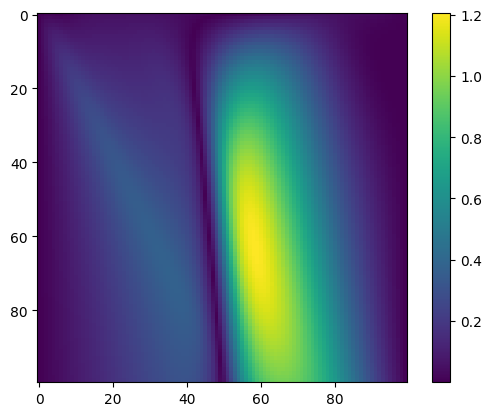

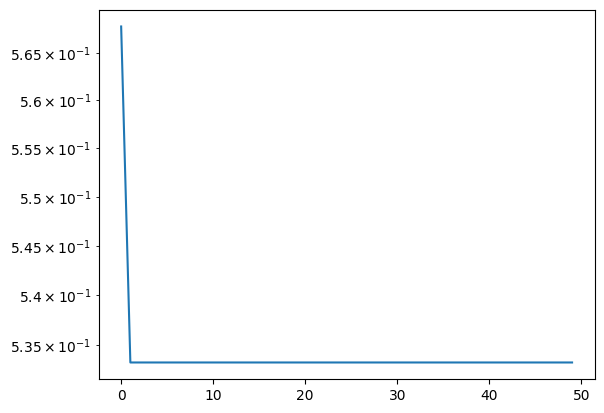

tensor([0.9794], device='cuda:0') tensor([0.9380], device='cuda:0')


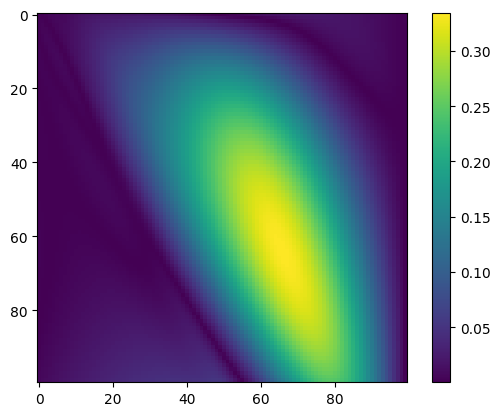

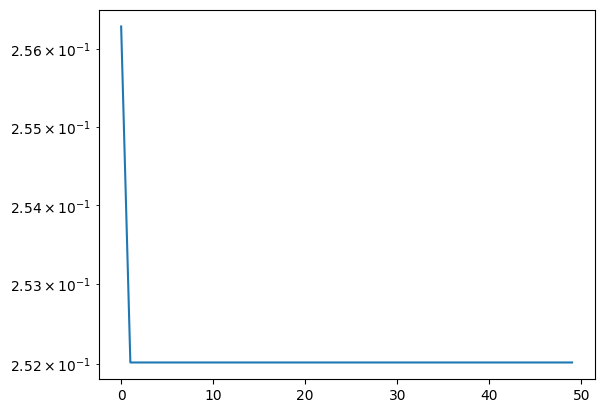

************************************************************
PINN Final Loss: 1.999858795898035e-05
PINN time: 3.7748891949653625 minutes

tensor([[0.9988],
        [0.0024]], device='cuda:0')
Generation time: 0.05929461320241292 minutes

Largest Loss (Using 2 Neurons): 1.9793576002120972

Largest Loss (Full grid) (Using 2 Neurons): 0.6561089754104614
Parameter Case: 0.005

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.7690, -0.1542], device='cuda:0') tensor([0.7677], device='cuda:0')


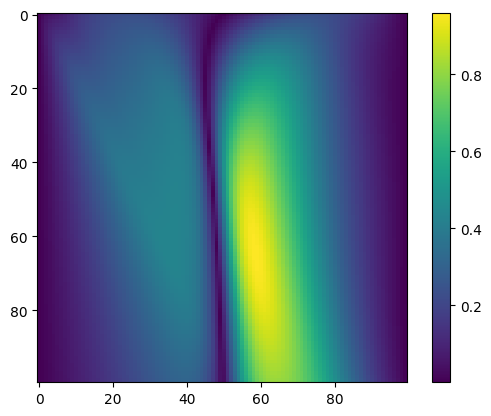

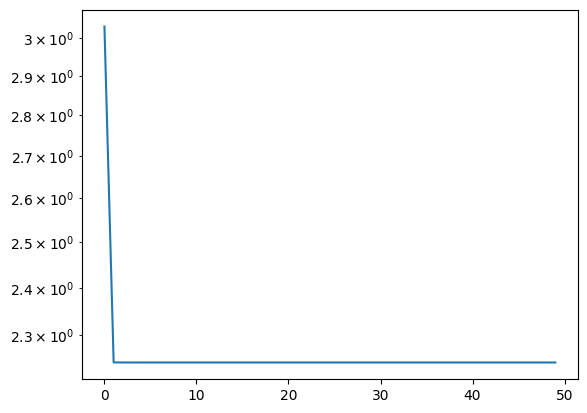

tensor([0.9946, 0.3495], device='cuda:0') tensor([0.7303], device='cuda:0')


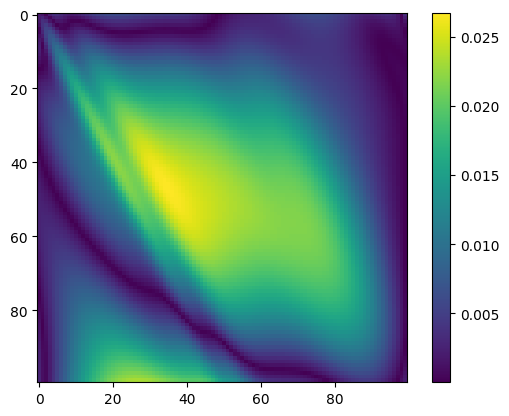

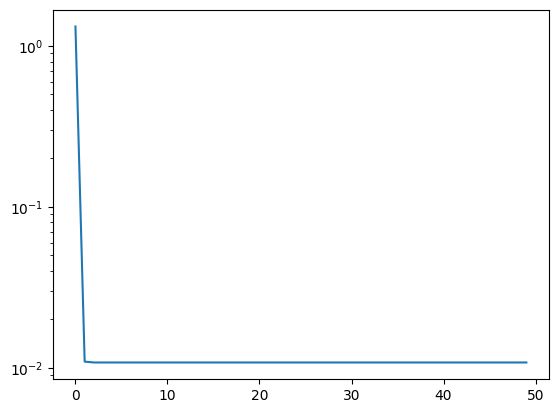

************************************************************
PINN Final Loss: 0.0001263691228814423
PINN time: 4.391149747371673 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024]], device='cuda:0')
Generation time: 0.2522944410641988 minutes

Largest Loss (Using 3 Neurons): 1.2668298482894897

Largest Loss (Full grid) (Using 3 Neurons): 4.6421709060668945
Parameter Case: 0.043867187499999995

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.8289, -0.7021, -0.1211], device='cuda:0') tensor([0.8265], device='cuda:0')


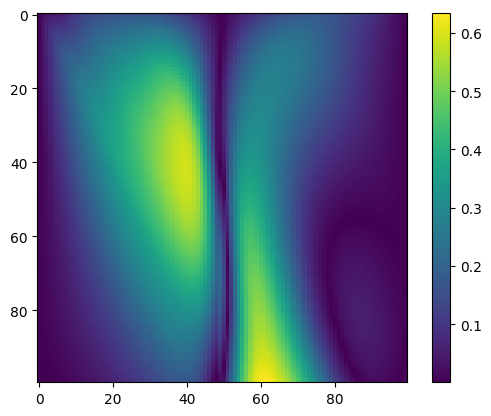

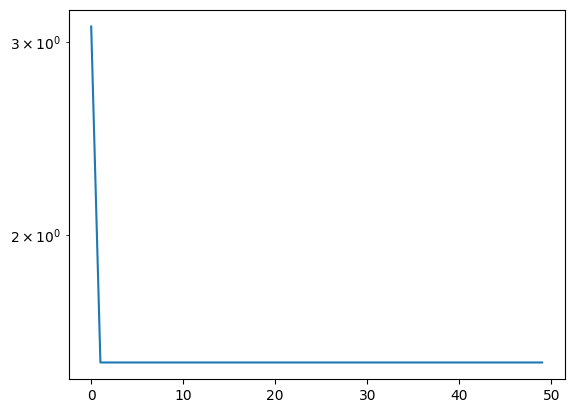

tensor([9.9608e-01, 3.3715e-01, 5.9241e-04], device='cuda:0') tensor([0.8256], device='cuda:0')


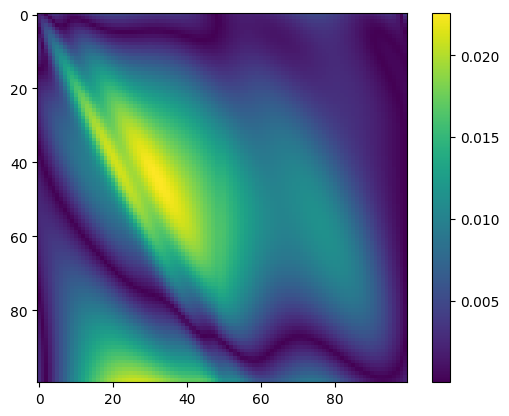

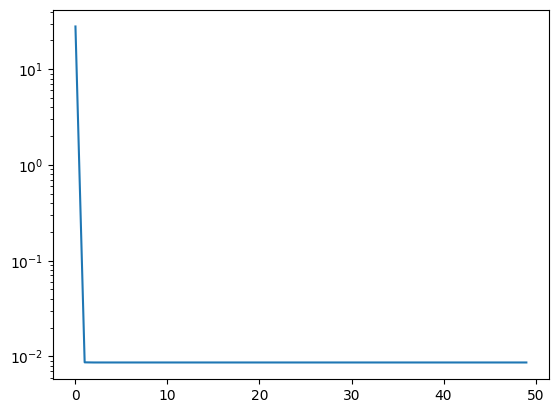

************************************************************
PINN Final Loss: 1.999895175686106e-05
PINN time: 1.6325894792874653 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097]], device='cuda:0')
Generation time: 0.7059179186820984 minutes

Largest Loss (Using 4 Neurons): 0.25221195816993713

Largest Loss (Full grid) (Using 4 Neurons): 2.5642940998077393
Parameter Case: 0.16046875

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9990, -1.0256, -0.2692, -0.5694], device='cuda:0') tensor([1.0014], device='cuda:0')


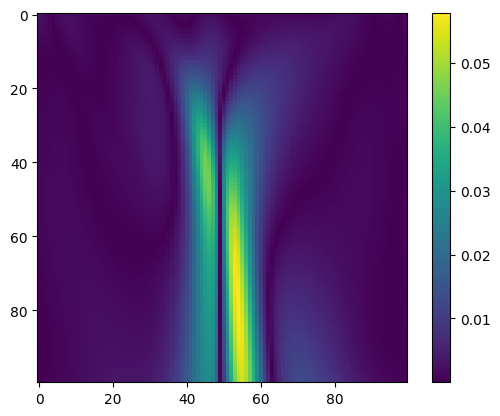

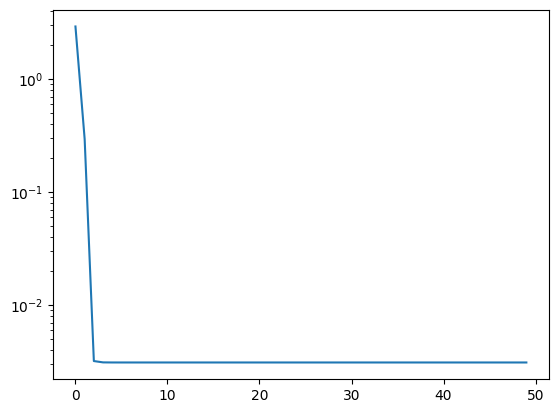

tensor([0.9964, 0.3296, 0.0024, 0.0031], device='cuda:0') tensor([0.9720], device='cuda:0')


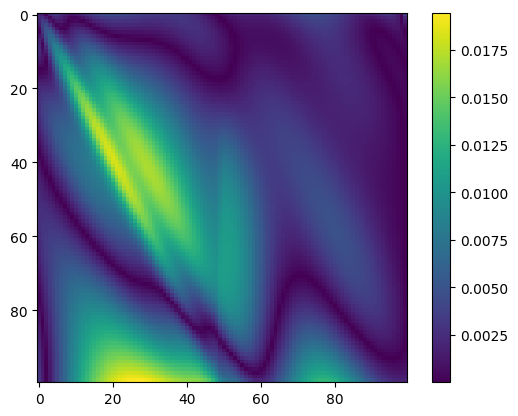

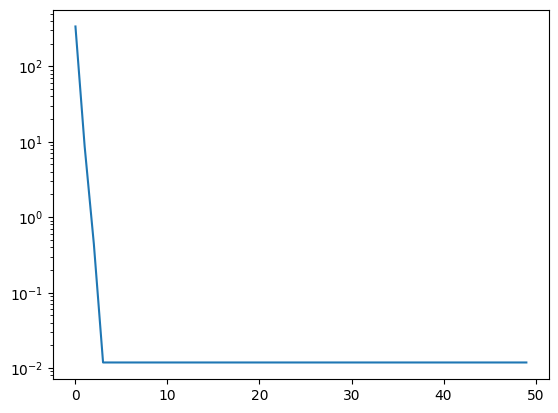

************************************************************
PINN Final Loss: 4.263166556484066e-05
PINN time: 4.668049804369608 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308]], device='cuda:0')
Generation time: 0.30398730834325155 minutes

Largest Loss (Using 5 Neurons): 0.24832652509212494

Largest Loss (Full grid) (Using 5 Neurons): 0.40847331285476685
Parameter Case: 0.0127734375

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9995, -1.0654, -0.2825, -0.5578,  0.0196], device='cuda:0') tensor([1.0024], device='cuda:0')


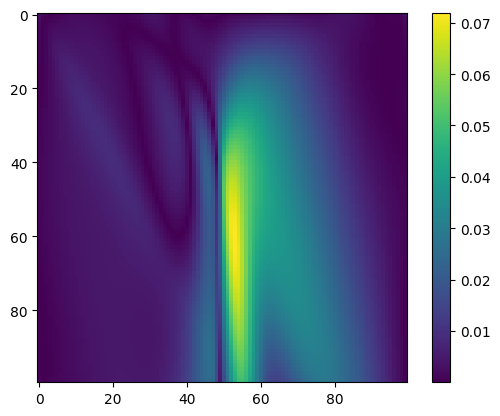

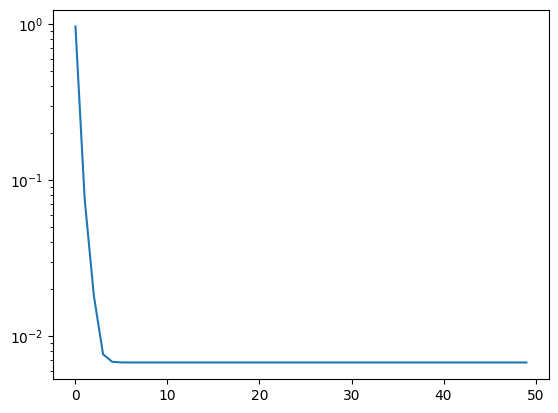

tensor([ 1.0008,  0.3226,  0.0086,  0.0060, -0.0102], device='cuda:0') tensor([0.9550], device='cuda:0')


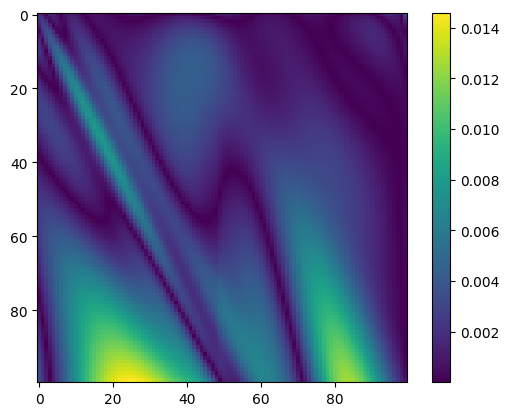

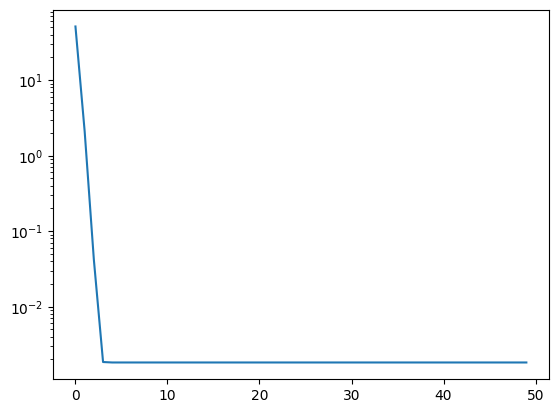

************************************************************
PINN Final Loss: 3.225786713301204e-05
PINN time: 4.675079115231832 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308],
        [ 0.0184]], device='cuda:0')
Generation time: 1.0761967778205872 minutes

Largest Loss (Using 6 Neurons): 0.17802464962005615

Largest Loss (Full grid) (Using 6 Neurons): 0.18230438232421875
Parameter Case: 0.020546875

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061],
        [-0.0505,  0.5051],
        [-0.0101,  0.6768]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 1.0051, -1.0431, -0.2670, -0.5556,  0.0466, -0.0081], device='cuda:0') tensor([1.0086], device='cuda:0')


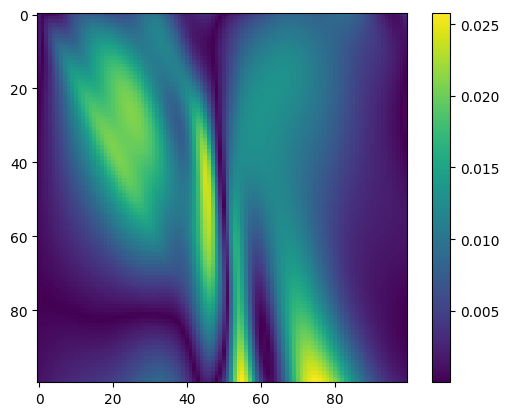

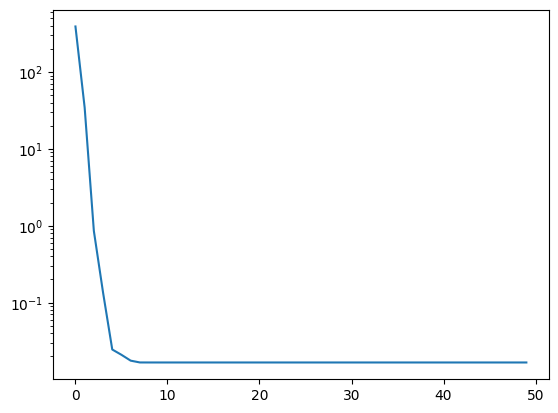

tensor([ 1.0004e+00,  3.2184e-01,  8.1055e-03,  6.1552e-03, -1.0047e-02,
         9.9068e-06], device='cuda:0') tensor([0.9600], device='cuda:0')


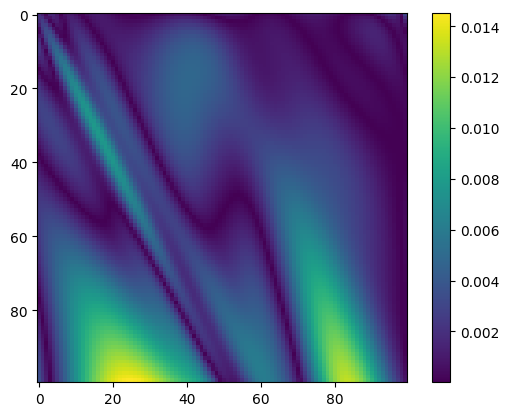

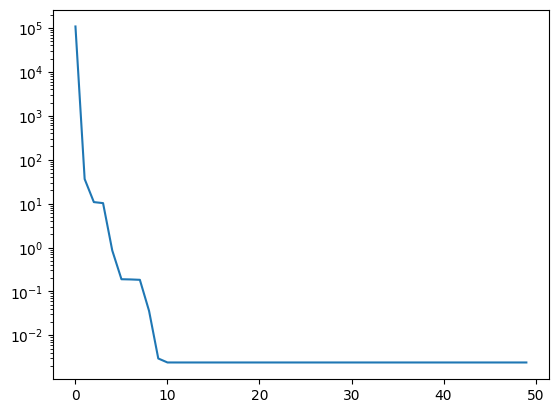

************************************************************
PINN Final Loss: 3.1392752134706825e-05
PINN time: 4.661066464583079 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308],
        [ 0.0184],
        [-0.0386]], device='cuda:0')
Generation time: 1.948971970876058 minutes

Largest Loss (Using 7 Neurons): 0.010184935294091702

Largest Loss (Full grid) (Using 7 Neurons): 0.029853083193302155
Parameter Case: 0.0749609375

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061],
        [-0.0505,  0.5051],
        [-0.0101,  0.6768],
        [ 0.1515,  0.7980],
        [ 0.0909,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9976, -1.0373, -0.2623, -0.5449,  0.0428, -0.0097,  0.0063],
       device='cuda:0') tensor([1.000

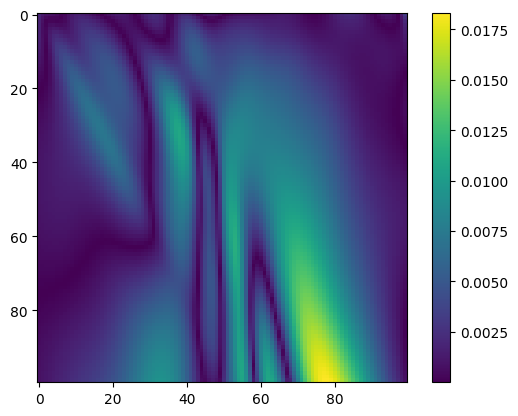

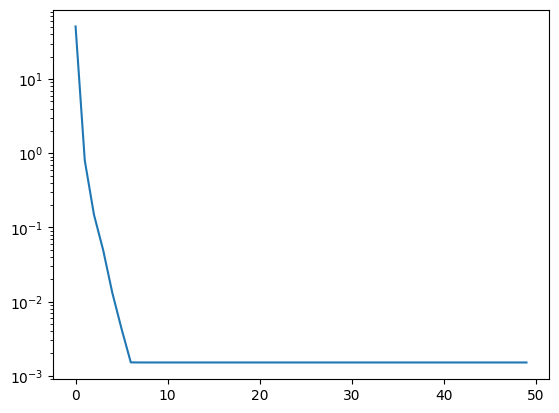

tensor([ 1.0011e+00,  3.1970e-01,  8.1604e-03,  5.2595e-03, -1.0785e-02,
        -1.4674e-04,  1.2779e-04], device='cuda:0') tensor([0.9989], device='cuda:0')


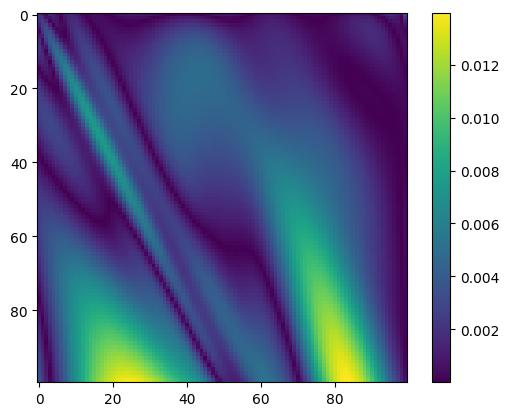

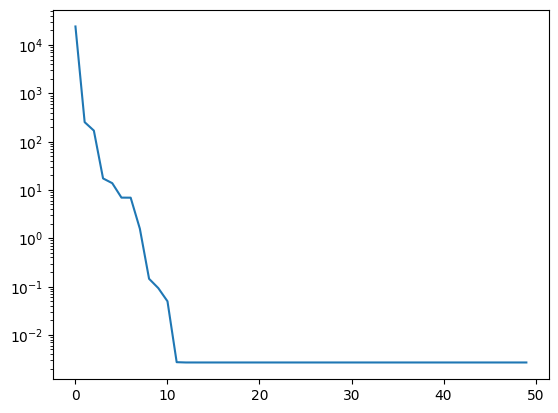

************************************************************
PINN Final Loss: 1.9980336219305173e-05
PINN time: 3.518038562933604 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308],
        [ 0.0184],
        [-0.0386],
        [ 0.0473]], device='cuda:0')
Generation time: 2.4249544024467466 minutes

Largest Loss (Using 8 Neurons): 0.003942358307540417

Largest Loss (Full grid) (Using 8 Neurons): 0.00584584753960371
Parameter Case: 0.28484375

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061],
        [-0.0505,  0.5051],
        [-0.0101,  0.6768],
        [ 0.1515,  0.7980],
        [ 0.0909,  1.0000],
        [ 0.1919,  0.6970],
        [ 0.3131,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9980, -1.0270, -0.2581, -

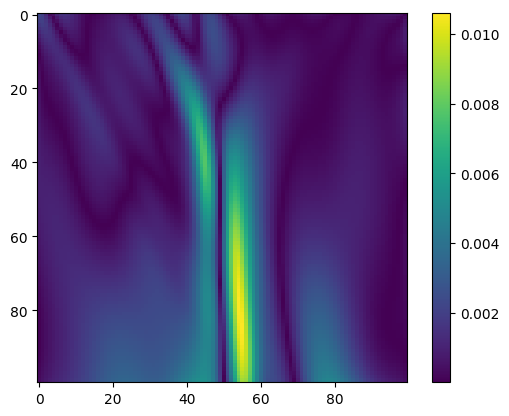

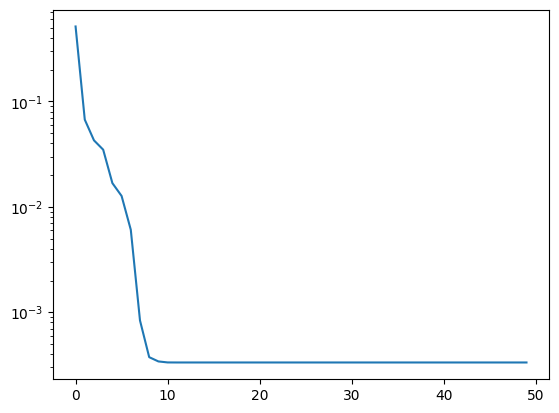

tensor([ 1.0010e+00,  3.2344e-01,  6.6377e-03,  3.6374e-03, -8.7751e-03,
        -6.5493e-04,  5.9723e-04, -8.1135e-04], device='cuda:0') tensor([0.9991], device='cuda:0')


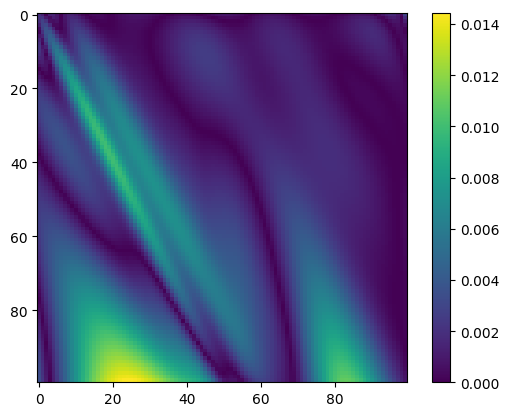

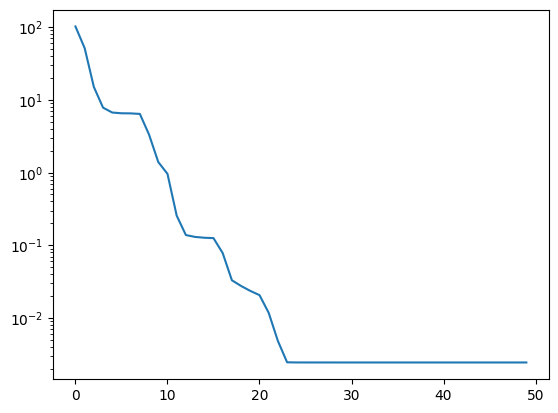

************************************************************
PINN Final Loss: 2.573944402683992e-05
PINN time: 4.6660594820976256 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308],
        [ 0.0184],
        [-0.0386],
        [ 0.0473],
        [ 0.0442]], device='cuda:0')
Generation time: 2.5039506753285727 minutes

Largest Loss (Using 9 Neurons): 0.003320191754028201

Largest Loss (Full grid) (Using 9 Neurons): 0.0055570658296346664
Parameter Case: 0.0283203125

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061],
        [-0.0505,  0.5051],
        [-0.0101,  0.6768],
        [ 0.1515,  0.7980],
        [ 0.0909,  1.0000],
        [ 0.1919,  0.6970],
        [ 0.3131,  1.0000],
        [ 0.3131,  0.8182],
        [ 0.7172,  1.0000]], 

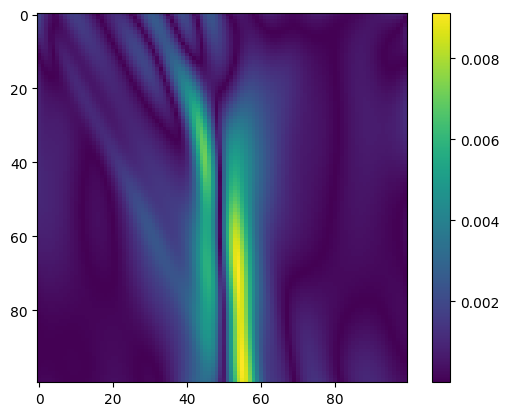

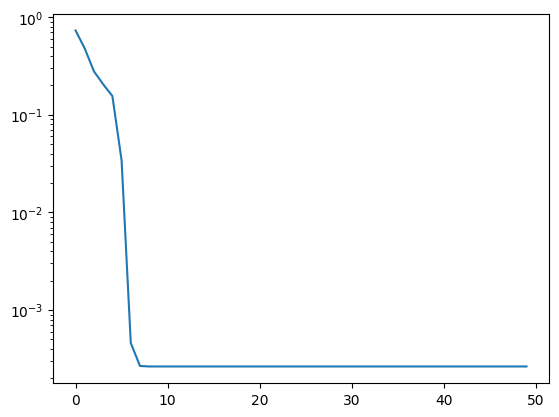

tensor([ 1.0011e+00,  3.2319e-01,  9.0710e-03,  6.6733e-04, -1.4096e-02,
        -3.6692e-03,  9.8277e-04, -4.5369e-03,  3.5016e-03], device='cuda:0') tensor([0.9997], device='cuda:0')


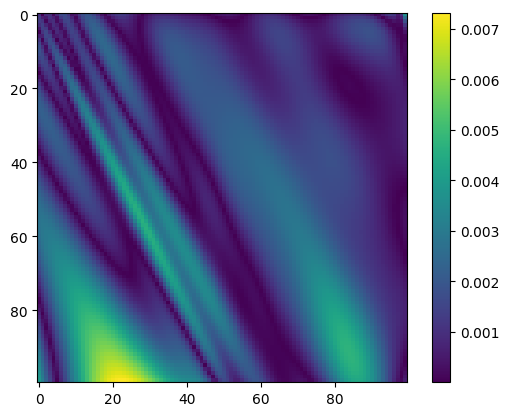

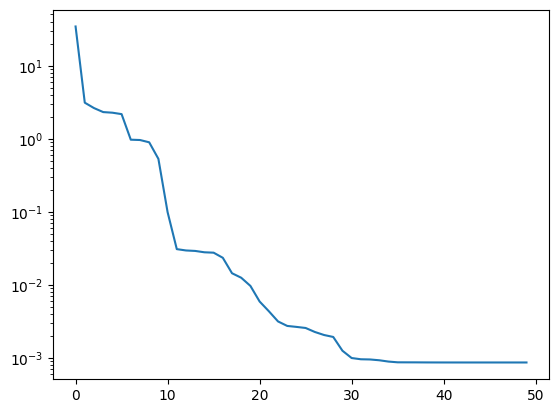

************************************************************
PINN Final Loss: 4.405206709634513e-05
PINN time: 4.664181419213613 minutes

tensor([[ 0.9988],
        [ 0.0024],
        [-0.0024],
        [-0.0097],
        [ 0.0308],
        [ 0.0184],
        [-0.0386],
        [ 0.0473],
        [ 0.0442],
        [ 0.2778]], device='cuda:0')
Generation time: 5.988984024524688 minutes

Largest Loss (Using 10 Neurons): 0.009333968162536621

Largest Loss (Full grid) (Using 10 Neurons): 0.008316002786159515
Parameter Case: 0.984453125

tensor([[-0.4949,  0.0000],
        [ 0.4747,  0.0202],
        [ 0.3333,  0.6364],
        [ 0.2929,  0.1313],
        [ 0.0101,  1.0000],
        [ 0.4949,  0.9899],
        [ 0.2121,  1.0000],
        [ 0.0505,  0.6667],
        [ 0.0303,  0.6061],
        [-0.0505,  0.5051],
        [-0.0101,  0.6768],
        [ 0.1515,  0.7980],
        [ 0.0909,  1.0000],
        [ 0.1919,  0.6970],
        [ 0.3131,  1.0000],
        [ 0.3131,  0.8182],
        [ 0.

In [3]:
print("GPT-PINN Training Started")
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    # No need to train over parameters already used as neurons
    b_train = np.delete(b_train, np.where(b_train == neuron)[0])
    
    ###########################################################################
    # Full PINN to be used as activation function
    nu = neuron
    
    t1 = time.time()
    PINN = NN(layers_pinn, nu).to(device)
    pinn_losses = pinn_train(PINN, nu, xt_resid, IC_xt, IC_u, BC_xt, BC_u, 
                             f_hat, epochs_pinn, lr_pinn, tol)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    ###########################################################################    
    # (S)GPT-PINN Training / Offline Generation
    c_initial  = c_init[i][0]

    if (sparse):
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_len,ALPHA,Lhat = gram_schmidt1_bic(PINN,i, xt_resid, out_full, out_t_full, out_x_full, out_xx_full, 
                                                 out_IC, out_BC, IC_xt, BC_xt,xt_test,out_test, f_hat, X_umax_idx, X_all_idx, X_train_all,L_hat)
        print(Lhat)
        if i==0:
            c_ui = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0

    else:
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_size = inputs(PINN, i, xt_resid, out_full, out_t_full, out_x_full, 
                          out_xx_full, out_IC, out_BC, IC_xt, BC_xt,  
                          out_test, xt_test,f_hat, xt_size, 
                          num_largest_mag, idx_list)

    if (train_final == False) and (i+1 == number_of_neurons):
        end = number_of_neurons-1
        break
    
    t1 = time.time()
    largest_loss, largest_case,trained_c,losses,largest_loss_full = offline_generation_lbfgs_full(b_train, xt_size, IC_size, 
    BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat,
    train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
    t2 = time.time()
    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes") 
    ###########################################################################
    loss_list[i] = largest_loss
    loss_list_full_grid[i] = largest_loss_full
    
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case

    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    print(f"\nLargest Loss (Full grid) (Using {i+1} Neurons): {largest_loss_full}")
    print(f"Parameter Case: {largest_case}\n")
    print(xt_resid[X_all_idx[:2*i+1]])
        
    if (i+1 == number_of_neurons):
        end = number_of_neurons
        break
    ###########################################################################
    if (sparse):
        nu = largest_case
        gram_schmidt2_zero(i, xt_resid,nu, trained_c, residual_full, 
                      out_full,out_t_full,out_x_full, out_xx_full, X_rmax_idx, 
                      X_all_idx, X_train_all)

    if plot_test:
        largest_loss, largest_case,trained_c1,losses1,_ = offline_generation_lbfgs_full([nu_test1], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx,out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
        plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
        print(trained_c1,sum(Lhat*trained_c1.view(-1,1)))
        plt.colorbar()
        plt.show()
        plt.plot(losses1)
        plt.yscale('log')
        plt.show()
        largest_loss, largest_case,trained_c2,losses2,_ = offline_generation_lbfgs_full([nu_test2], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat,train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
        plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
        print(trained_c2,sum(Lhat*trained_c.view(-1,1)))
        plt.colorbar()
        plt.show()
        plt.plot(losses2)
        plt.yscale('log')
        plt.show()

total_time = (time.time() - total_time_1) / 3600      

print(print_seperator)
print("GPT-PINN Training Ended\n")
print(f"Total training time: {total_time} Hours\n")
print(f"Activation function parameters: \n{neurons}\n")
print(f"Largest loss list: \n{loss_list[:end]}\n")

GPT-PINN Training Started
************************************************************
PINN Final Loss: 1.9998893549200147e-05
PINN time: 2.1516313314437867 minutes

tensor([[0.9997]], device='cuda:0')
Generation time: 0.07933949232101441 minutes

Largest Loss (Using 1 Neurons): 0.584023118019104

Largest Loss (Full grid) (Using 1 Neurons): 0.9215335249900818
Parameter Case: 0.9922265625

tensor([[-0.4949,  0.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([0.9430], device='cuda:0') tensor([0.9427], device='cuda:0')


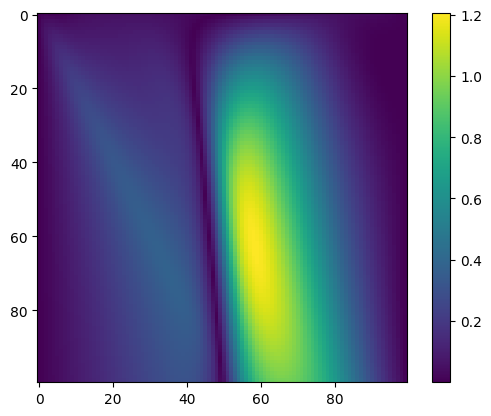

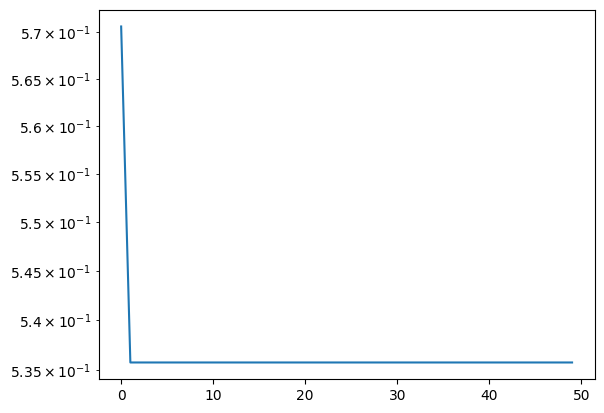

tensor([0.9798], device='cuda:0') tensor([0.9426], device='cuda:0')


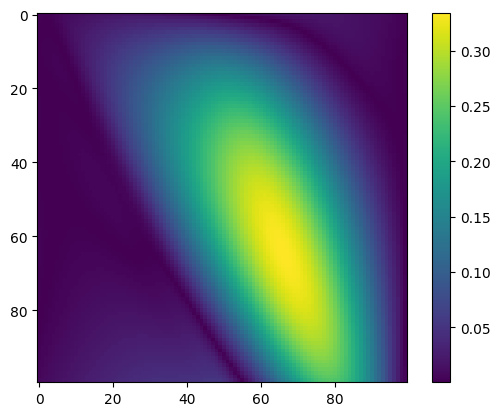

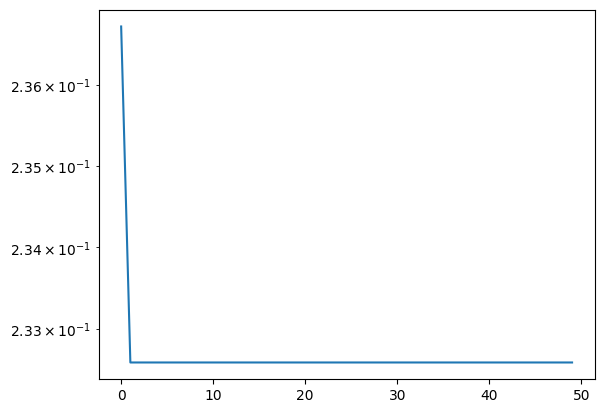

************************************************************
PINN Final Loss: 3.101695983787067e-05
PINN time: 4.634068206946055 minutes

tensor([[0.9997],
        [0.0019]], device='cuda:0')
Generation time: 0.06124945084253947 minutes

Largest Loss (Using 2 Neurons): 1.5773508548736572

Largest Loss (Full grid) (Using 2 Neurons): 0.45632046461105347
Parameter Case: 0.03609375

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.7980, -0.3639], device='cuda:0') tensor([0.7970], device='cuda:0')


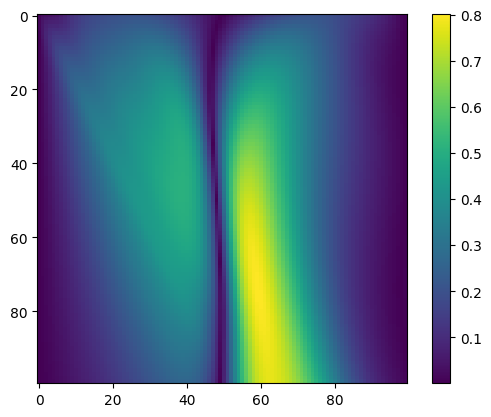

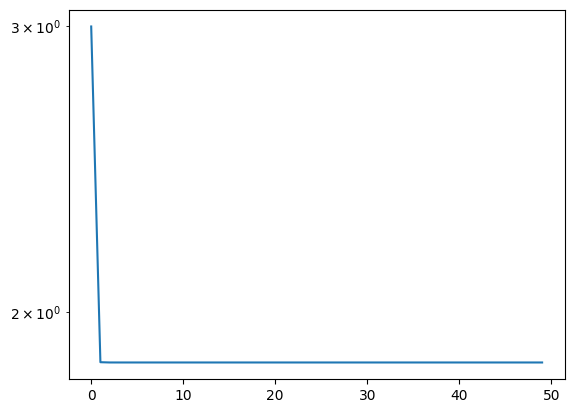

tensor([0.9934, 0.3371], device='cuda:0') tensor([0.7834], device='cuda:0')


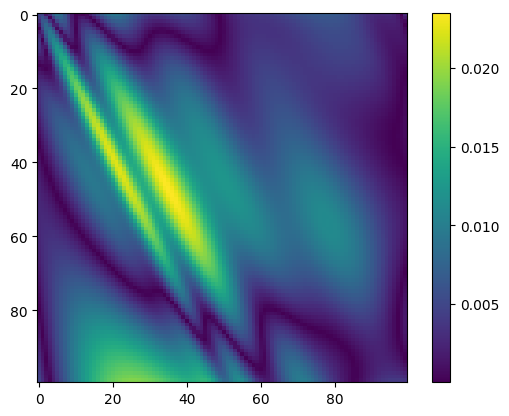

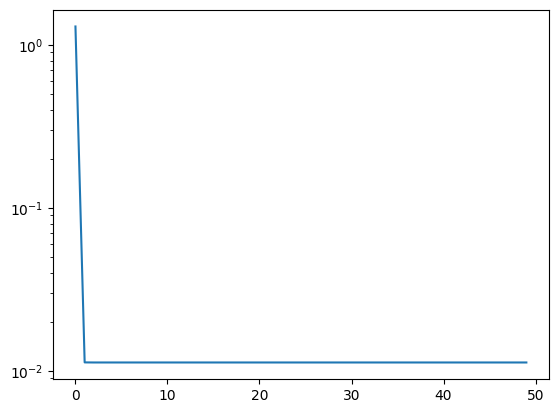

************************************************************
PINN Final Loss: 1.999956111831125e-05
PINN time: 4.313676830132803 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081]], device='cuda:0')
Generation time: 0.4629256248474121 minutes

Largest Loss (Using 3 Neurons): 0.5447301864624023

Largest Loss (Full grid) (Using 3 Neurons): 0.5859968662261963
Parameter Case: 0.1371484375

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9961, -1.1002, -0.8043], device='cuda:0') tensor([1.0001], device='cuda:0')


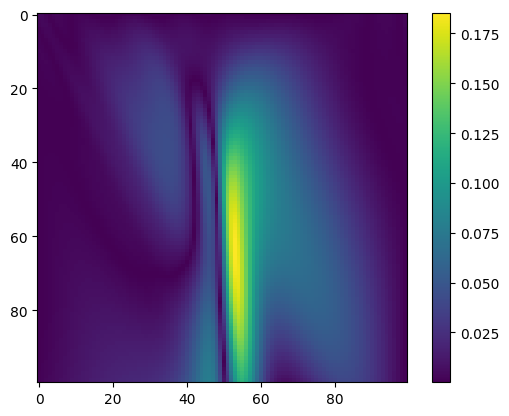

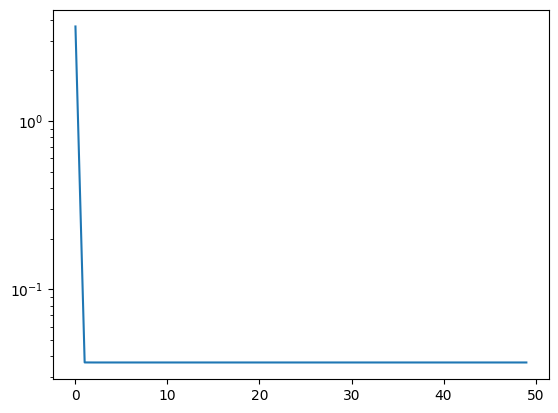

tensor([0.9950, 0.3410, 0.0028], device='cuda:0') tensor([0.9389], device='cuda:0')


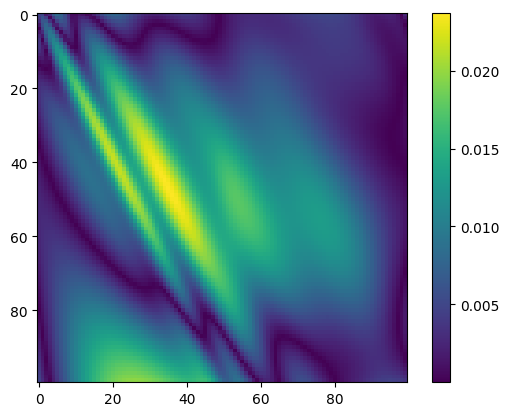

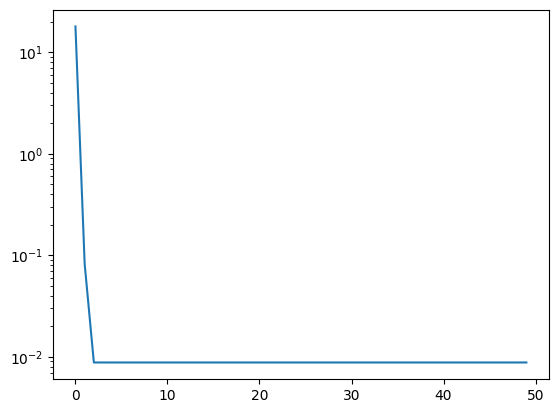

************************************************************
PINN Final Loss: 2.5693196221254766e-05
PINN time: 4.631397473812103 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139]], device='cuda:0')
Generation time: 0.2703439950942993 minutes

Largest Loss (Using 4 Neurons): 0.015025620348751545

Largest Loss (Full grid) (Using 4 Neurons): 0.07313946634531021
Parameter Case: 0.059414062499999996

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9962, -1.0353, -0.5456,  0.1894], device='cuda:0') tensor([1.0010], device='cuda:0')


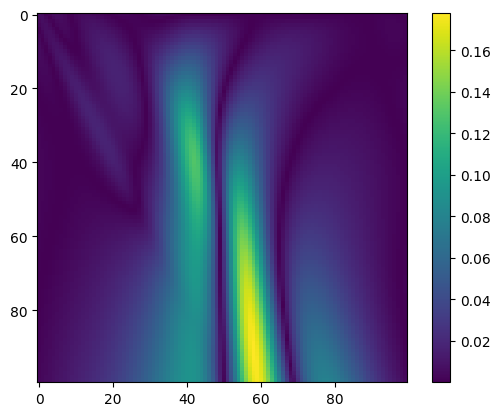

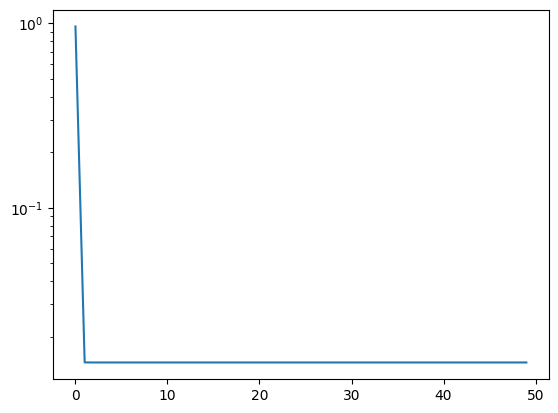

tensor([ 1.0001,  0.3350,  0.0108, -0.0098], device='cuda:0') tensor([1.0000], device='cuda:0')


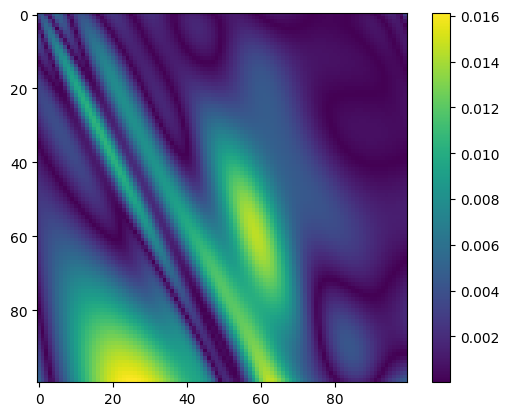

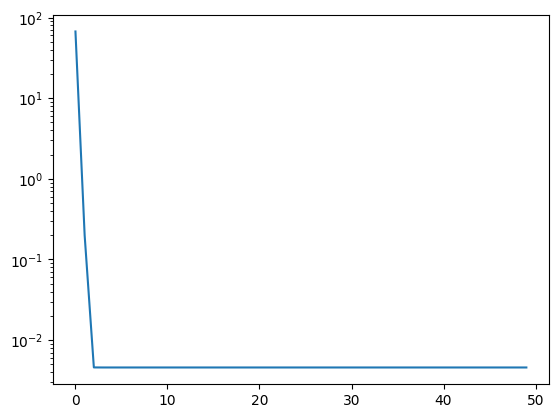

************************************************************
PINN Final Loss: 1.9981180230388418e-05
PINN time: 1.5817193150520326 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380]], device='cuda:0')
Generation time: 1.1173858880996703 minutes

Largest Loss (Using 5 Neurons): 0.021464085206389427

Largest Loss (Full grid) (Using 5 Neurons): 0.017141297459602356
Parameter Case: 0.269296875

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9970, -1.0139, -0.7038,  0.0868, -0.0464], device='cuda:0') tensor([0.9999], device='cuda:0')


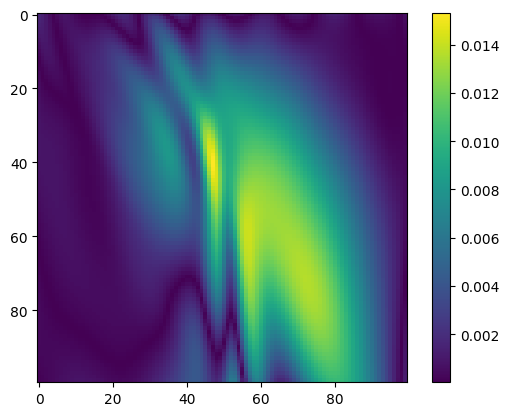

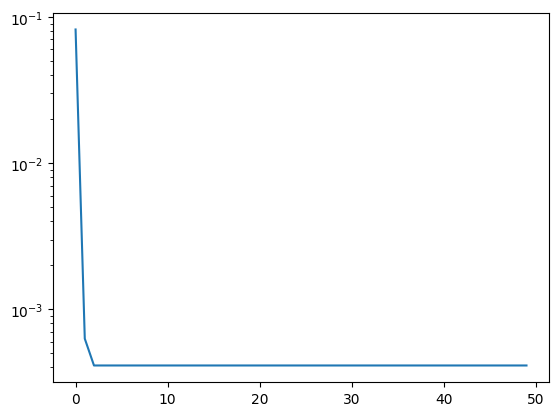

tensor([ 9.9911e-01,  3.3769e-01,  4.6359e-03, -3.9578e-03,  7.7329e-05],
       device='cuda:0') tensor([0.9969], device='cuda:0')


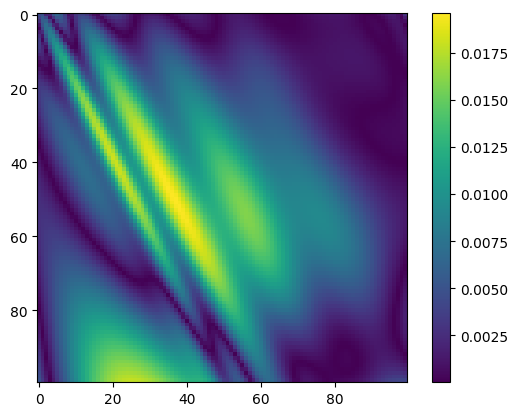

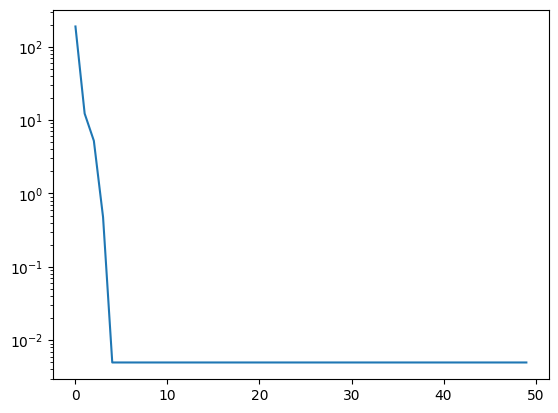

************************************************************
PINN Final Loss: 1.9967765183537267e-05
PINN time: 2.475667142868042 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380],
        [ 0.0490]], device='cuda:0')
Generation time: 0.4475464463233948 minutes

Largest Loss (Using 6 Neurons): 0.0027266049291938543

Largest Loss (Full grid) (Using 6 Neurons): 0.0010306205367669463
Parameter Case: 0.0905078125

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899],
        [-0.0505,  0.5758],
        [ 0.6768,  1.0000]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 0.9973, -1.0133, -0.6970,  0.0892, -0.0489, -0.0033], device='cuda:0') tensor([0.9999], device='cuda:0')


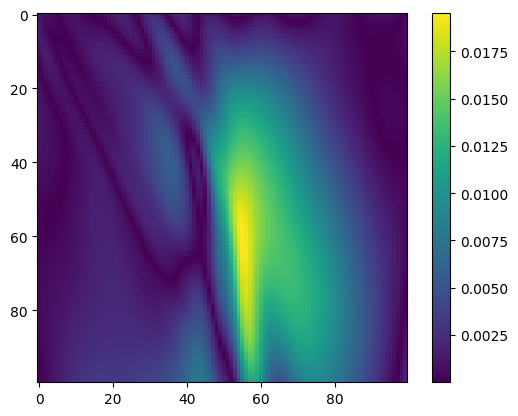

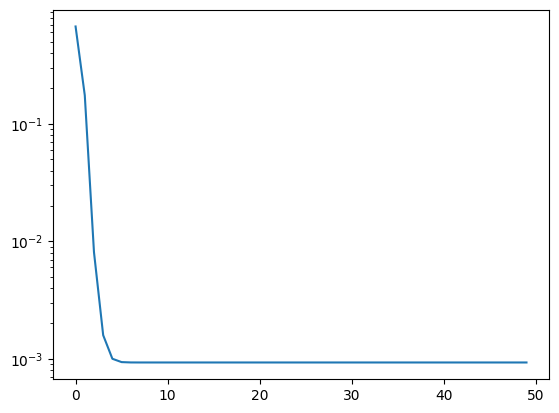

tensor([ 0.9996,  0.3348,  0.0078, -0.0110, -0.0045,  0.0049], device='cuda:0') tensor([0.9997], device='cuda:0')


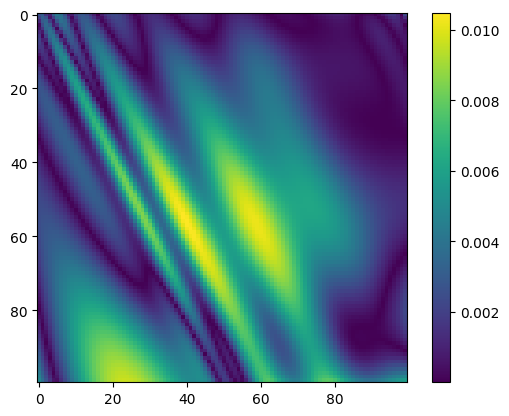

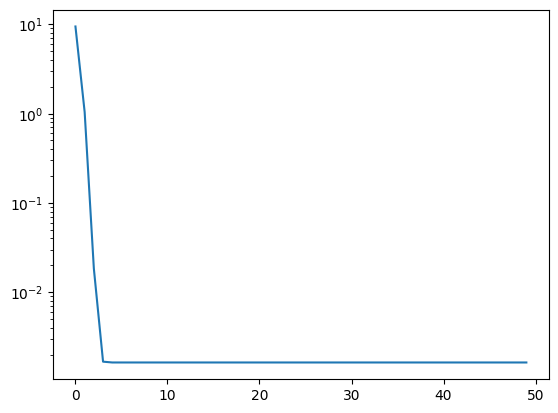

************************************************************
PINN Final Loss: 1.9999744836241007e-05
PINN time: 4.474088037014008 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380],
        [ 0.0490],
        [ 0.2439]], device='cuda:0')
Generation time: 1.4703952590624492 minutes

Largest Loss (Using 7 Neurons): 0.0008385024848394096

Largest Loss (Full grid) (Using 7 Neurons): 0.0011797607876360416
Parameter Case: 0.7745703125

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899],
        [-0.0505,  0.5758],
        [ 0.6768,  1.0000],
        [ 0.0505,  0.7576],
        [ 0.0505,  0.7071]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 9.9445e-01, -1.0296e+00, -7.0978e-01,  8.2203e-02, -4.1825e-02,
        -6.9599e-04,  1.1387e-02]

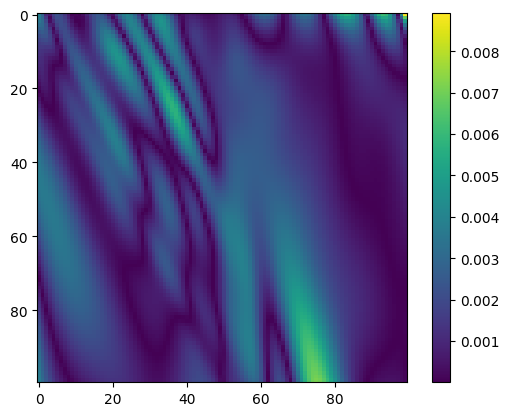

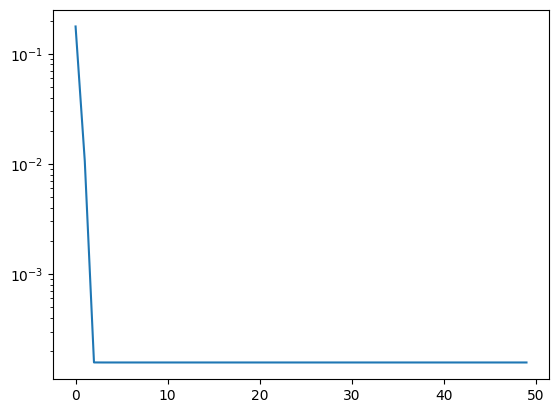

tensor([ 9.9900e-01,  3.3637e-01,  7.3525e-03, -1.0585e-02, -4.8067e-03,
         6.5705e-03,  6.0280e-04], device='cuda:0') tensor([0.9994], device='cuda:0')


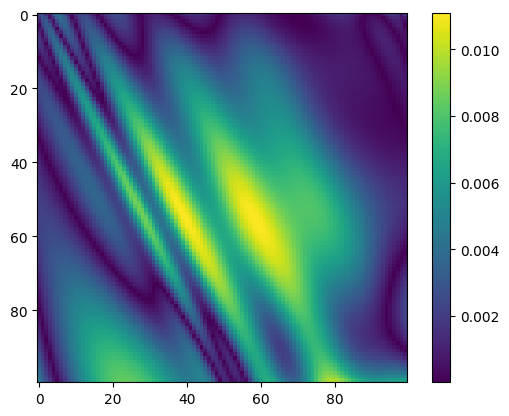

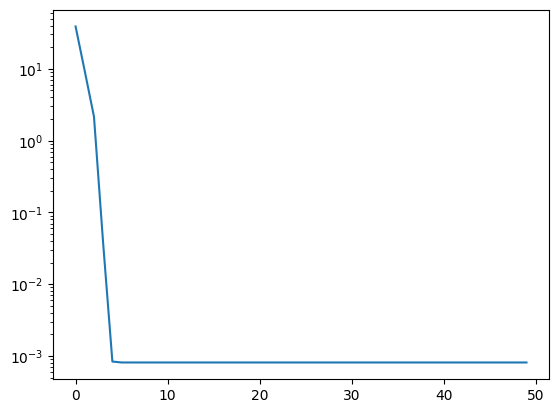

************************************************************
PINN Final Loss: 2.4425258743576705e-05
PINN time: 4.6344003240267435 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380],
        [ 0.0490],
        [ 0.2439],
        [-0.1227]], device='cuda:0')
Generation time: 1.2401697079340617 minutes

Largest Loss (Using 8 Neurons): 4.10043794545345e-05

Largest Loss (Full grid) (Using 8 Neurons): 0.00010437865421408787
Parameter Case: 0.3703515625

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899],
        [-0.0505,  0.5758],
        [ 0.6768,  1.0000],
        [ 0.0505,  0.7576],
        [ 0.0505,  0.7071],
        [ 0.3737,  0.8889],
        [-0.1717,  0.6263]], device='cuda:0', grad_fn=<IndexBackward0>)
tensor([ 9.9537e-01, -1.0294e+

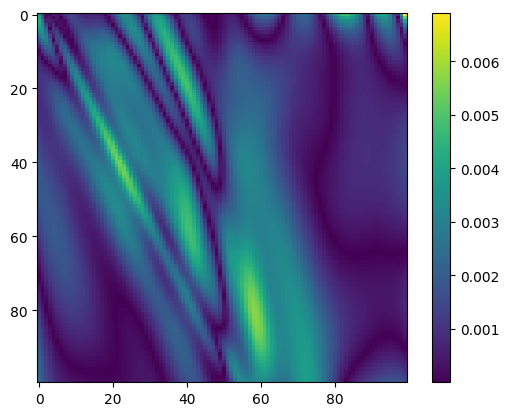

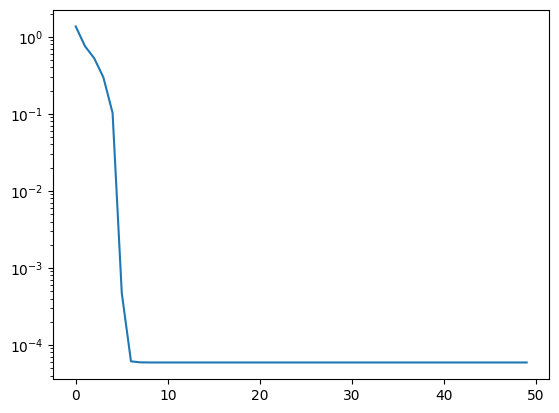

tensor([ 9.9838e-01,  3.2960e-01,  4.3675e-03, -1.8376e-02, -8.5088e-03,
         9.3901e-04,  2.3315e-03, -1.0608e-02], device='cuda:0') tensor([1.0000], device='cuda:0')


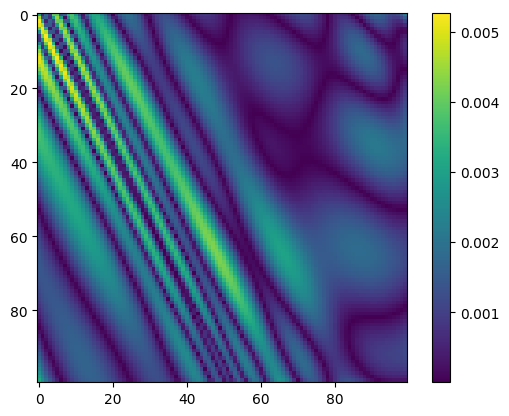

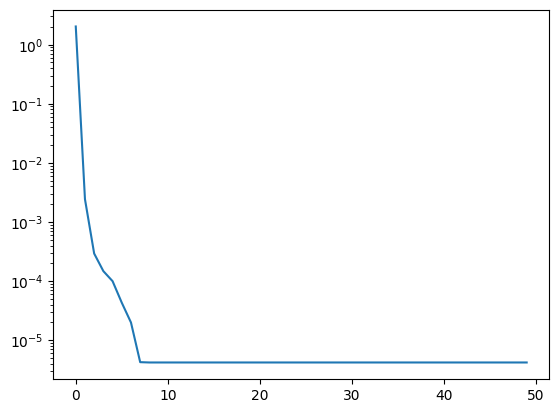

************************************************************
PINN Final Loss: 1.9995753973489627e-05
PINN time: 3.6135640223821004 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380],
        [ 0.0490],
        [ 0.2439],
        [-0.1227],
        [-0.1167]], device='cuda:0')
Generation time: 1.5246407747268678 minutes

Largest Loss (Using 9 Neurons): 3.798325633397326e-05

Largest Loss (Full grid) (Using 9 Neurons): 8.856946806190535e-05
Parameter Case: 0.051640624999999996

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899],
        [-0.0505,  0.5758],
        [ 0.6768,  1.0000],
        [ 0.0505,  0.7576],
        [ 0.0505,  0.7071],
        [ 0.3737,  0.8889],
        [-0.1717,  0.6263],
        [-0.5152,  0.4747],
        [ 1.0000,  

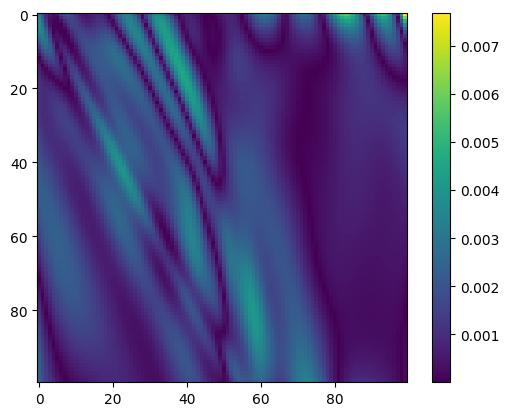

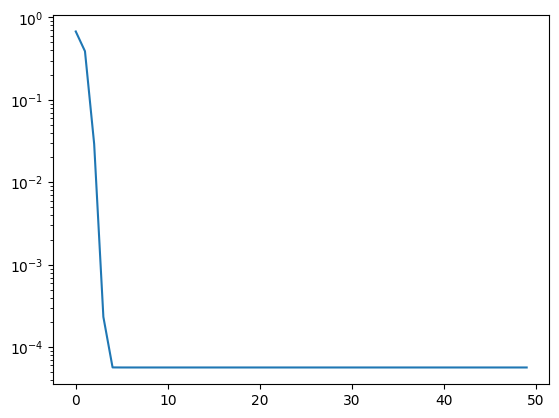

tensor([ 9.9834e-01,  3.2939e-01,  4.4997e-03, -1.8415e-02, -8.4837e-03,
         1.3346e-03,  2.4980e-03, -1.0497e-02,  2.9092e-04], device='cuda:0') tensor([1.0000], device='cuda:0')


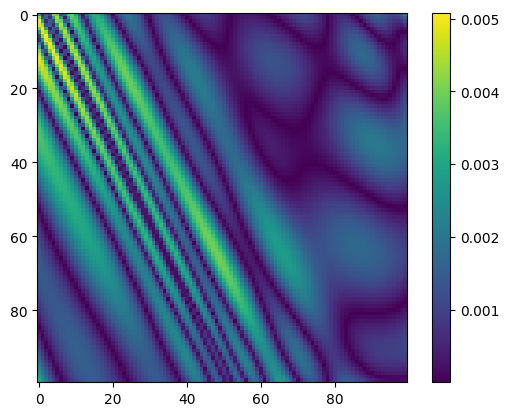

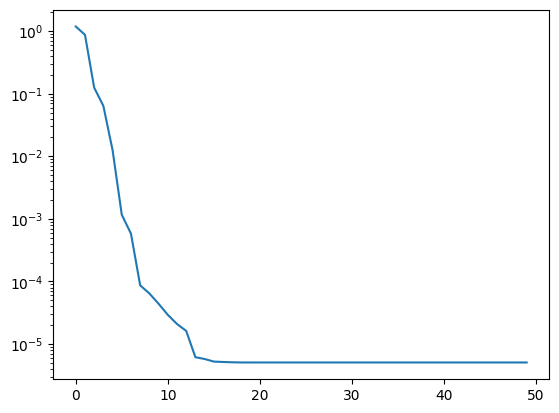

************************************************************
PINN Final Loss: 1.9961120415246114e-05
PINN time: 3.41841607093811 minutes

tensor([[ 0.9997],
        [ 0.0019],
        [-0.0081],
        [ 0.0139],
        [ 0.0380],
        [ 0.0490],
        [ 0.2439],
        [-0.1227],
        [-0.1167],
        [ 0.5091]], device='cuda:0')
Generation time: 3.522112560272217 minutes

Largest Loss (Using 10 Neurons): 2.7455307645141147e-05

Largest Loss (Full grid) (Using 10 Neurons): 5.473534838529304e-05
Parameter Case: 0.6191015625

tensor([[-0.4949,  0.0000],
        [ 0.4343,  0.0909],
        [ 0.3333,  0.6364],
        [-0.8990,  0.0707],
        [ 0.1515,  1.0000],
        [-0.0707,  0.6667],
        [-0.3737,  0.3838],
        [ 0.1515,  0.5051],
        [ 0.2525,  0.9899],
        [-0.0505,  0.5758],
        [ 0.6768,  1.0000],
        [ 0.0505,  0.7576],
        [ 0.0505,  0.7071],
        [ 0.3737,  0.8889],
        [-0.1717,  0.6263],
        [-0.5152,  0.4747],
        

In [9]:
print("GPT-PINN Training Started")
total_time_1 = time.time()
for i, neuron in enumerate(neurons):
    print(print_seperator)
    # No need to train over parameters already used as neurons
    b_train = np.delete(b_train, np.where(b_train == neuron)[0])
    
    ###########################################################################
    # Full PINN to be used as activation function
    nu = neuron
    
    t1 = time.time()
    PINN = NN(layers_pinn, nu).to(device)
    pinn_losses = pinn_train(PINN, nu, xt_resid, IC_xt, IC_u, BC_xt, BC_u, 
                             f_hat, epochs_pinn, lr_pinn, tol)
    t2 = time.time()
    print(f"PINN time: {(t2-t1)/60} minutes\n")
    ###########################################################################    
    # (S)GPT-PINN Training / Offline Generation
    c_initial  = c_init[i][0]

    if (sparse):
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_len,ALPHA,Lhat = gram_schmidt1_bic(PINN,i, xt_resid, out_full, out_t_full, out_x_full, out_xx_full, 
                                                 out_IC, out_BC, IC_xt, BC_xt,xt_test,out_test, f_hat, X_umax_idx, X_all_idx, X_train_all,L_hat)
        print(Lhat)
        if i==0:
            c_ui = PINN(xt_resid)
            c_x_umax_idx = torch.argmax(torch.abs(c_ui))
            if c_ui[c_x_umax_idx]<0:
                c_initial[i] = -1.0
        else:
            c_initial[:i] = ALPHA.squeeze()
            c_initial[i] = 0.0

    else:
        train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, \
        train_out_BC,fhat,xt_size = inputs(PINN, i, xt_resid, out_full, out_t_full, out_x_full, 
                          out_xx_full, out_IC, out_BC, IC_xt, BC_xt,  
                          out_test, xt_test,f_hat, xt_size, 
                          num_largest_mag, idx_list)

    if (train_final == False) and (i+1 == number_of_neurons):
        end = number_of_neurons-1
        break
    
    t1 = time.time()
    largest_loss, largest_case,trained_c,losses,largest_loss_full = offline_generation_lbfgs_full(b_train, xt_size, IC_size, 
    BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat,
    train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
    t2 = time.time()
    generation_time[i] = (t2-t1)/60
    print(f"Generation time: {(t2-t1)/60} minutes") 
    ###########################################################################
    loss_list[i] = largest_loss
    loss_list_full_grid[i] = largest_loss_full
    
    if (i+1 < number_of_neurons):
        neurons[i+1] = largest_case

    print(f"\nLargest Loss (Using {i+1} Neurons): {largest_loss}")
    print(f"\nLargest Loss (Full grid) (Using {i+1} Neurons): {largest_loss_full}")
    print(f"Parameter Case: {largest_case}\n")
    print(xt_resid[X_all_idx[:2*i+1]])
        
    if (i+1 == number_of_neurons):
        end = number_of_neurons
        break
    ###########################################################################
    if (sparse):
        nu = largest_case
        gram_schmidt2_zero(i, xt_resid,nu, trained_c, residual_full, 
                      out_full,out_t_full,out_x_full, out_xx_full, X_rmax_idx, 
                      X_all_idx, X_train_all)

    if plot_test:
        largest_loss, largest_case,trained_c1,losses1,_ = offline_generation_lbfgs_full([nu_test1], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx,out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat, train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
        plt.imshow((abs(PINN1(xt_test).view(-1)-out_test[:,:i+1]@trained_c1)).reshape(100,100).detach().cpu().numpy())
        print(trained_c1,sum(Lhat*trained_c1.view(-1,1)))
        plt.colorbar()
        plt.show()
        plt.plot(losses1)
        plt.yscale('log')
        plt.show()
        largest_loss, largest_case,trained_c2,losses2,_ = offline_generation_lbfgs_full([nu_test2], xt_size, IC_size, BC_size, IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, out_full[:,:i+1], out_x_full[:,:i+1], out_t_full[:,:i+1], out_xx_full[:,:i+1], f_hat,train_out_IC, train_out_BC, fhat, epochs_gpt_train, lr_gpt, neurons, i,Lhat,c_initial)
        plt.imshow((abs(PINN2(xt_test).view(-1)-out_test[:,:i+1]@trained_c2)).reshape(100,100).detach().cpu().numpy())
        print(trained_c2,sum(Lhat*trained_c.view(-1,1)))
        plt.colorbar()
        plt.show()
        plt.plot(losses2)
        plt.yscale('log')
        plt.show()

total_time = (time.time() - total_time_1) / 3600      

print(print_seperator)
print("GPT-PINN Training Ended\n")
print(f"Total training time: {total_time} Hours\n")
print(f"Activation function parameters: \n{neurons}\n")
print(f"Largest loss list: \n{loss_list[:end]}\n")

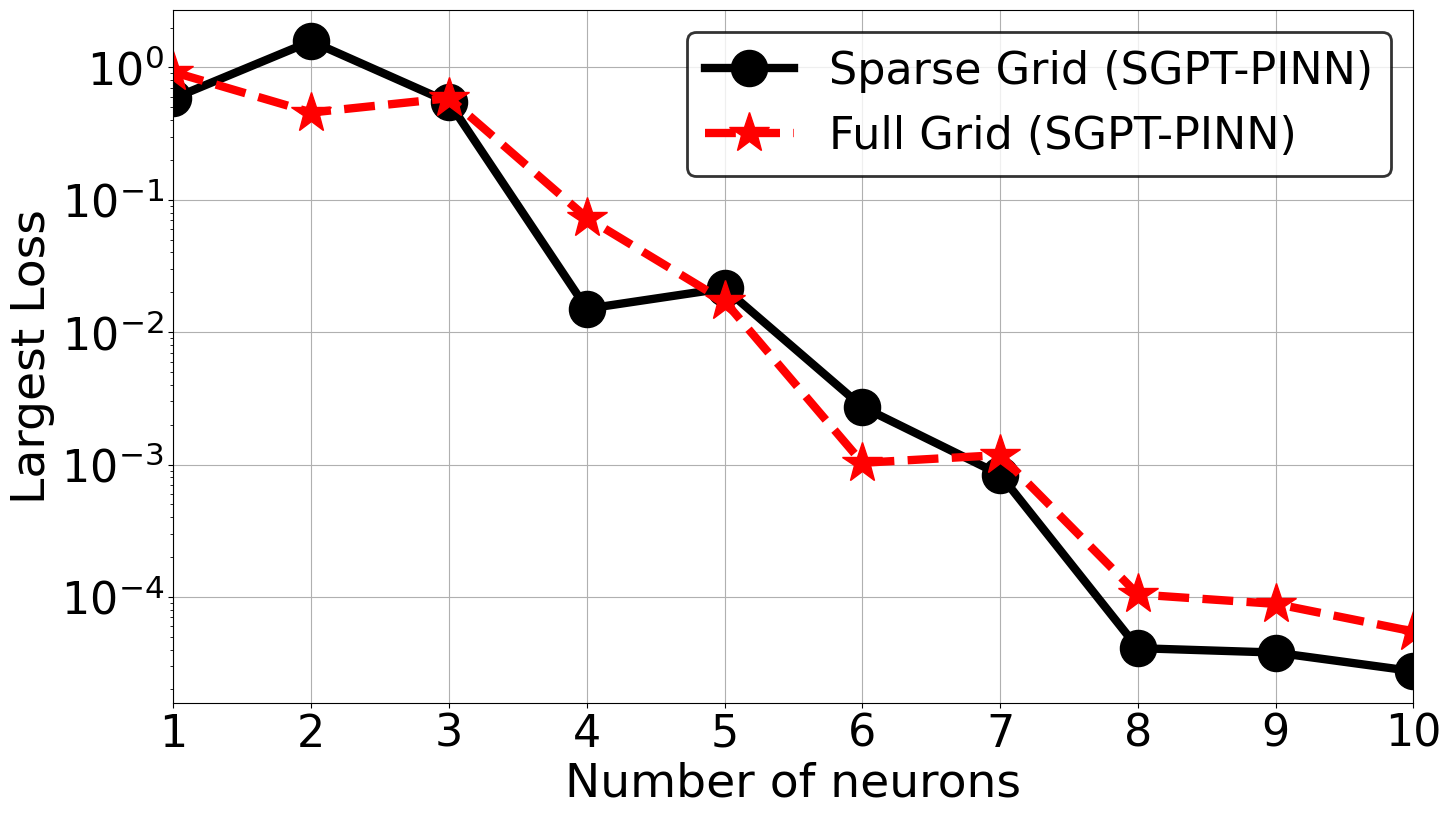

In [10]:
fig, ax = plt.subplots(figsize=(16,9))
min_neuron = 0
max_neuron = number_of_neurons
x = range(min_neuron+1,max_neuron+1)
ax.plot(x, loss_list[min_neuron:max_neuron], color="black", linestyle="solid",  marker="o", ms=26, label="Sparse Grid (SGPT-PINN)", lw=6)
ax.plot(x, loss_list_full_grid[min_neuron:max_neuron],   color="red",   linestyle="dashed", marker="*", ms=30, label="Full Grid (SGPT-PINN)",   lw=6)
ax.set_xticks(ticks=x)
ax.set_xlim(min(x),max(x))
ax.set_yscale("log")
ax.set_xlabel("Number of neurons", fontsize=34)
ax.set_ylabel("Largest Loss", fontsize=34)
legend = ax.legend(frameon=True, fontsize=32)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.grid()
ax.tick_params(axis='both', which='major', labelsize=32)
plt.show()

In [11]:
print(loss_list, loss_list_full_grid)

[5.84023118e-01 1.57735085e+00 5.44730186e-01 1.50256203e-02
 2.14640852e-02 2.72660493e-03 8.38502485e-04 4.10043795e-05
 3.79832563e-05 2.74553076e-05] [9.21533525e-01 4.56320465e-01 5.85996866e-01 7.31394663e-02
 1.71412975e-02 1.03062054e-03 1.17976079e-03 1.04378654e-04
 8.85694681e-05 5.47353484e-05]


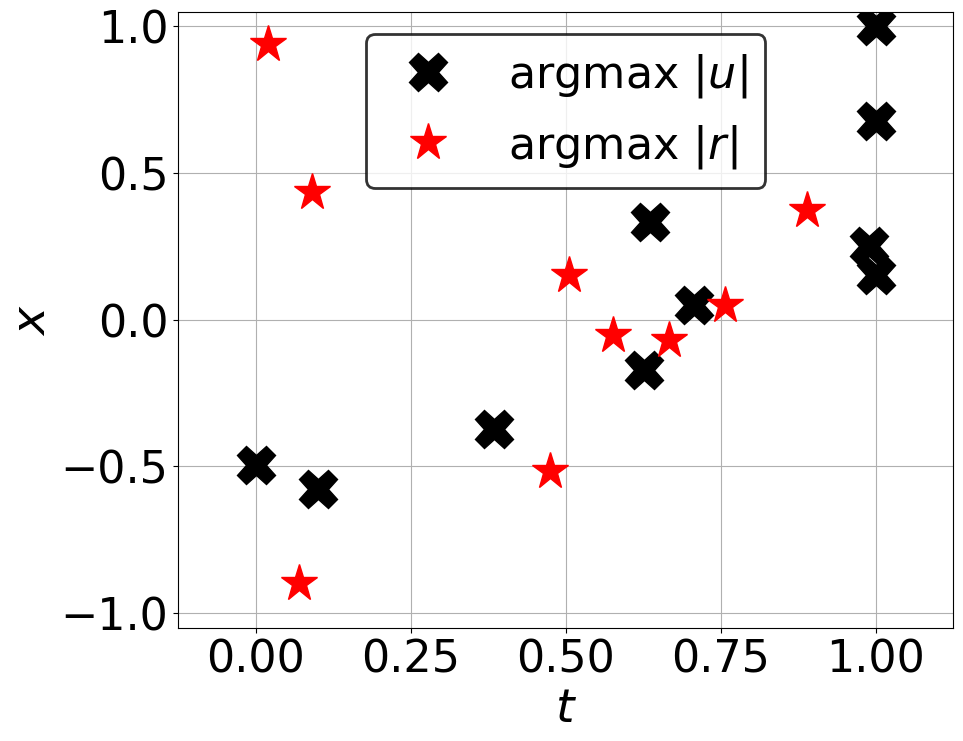

In [12]:
x_u = xt_resid[X_umax_idx,0].cpu().detach().numpy()
t_u = xt_resid[X_umax_idx,1].cpu().detach().numpy()

x_r = xt_resid[X_rmax_idx,0].cpu().detach().numpy()
t_r = xt_resid[X_rmax_idx,1].cpu().detach().numpy()

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(t_u, x_u, "X", color="black", label="argmax $|u|$", markersize=28)
ax.plot(t_r, x_r, "*", color="red",   label="argmax $|r|$", markersize=28)
ax.set_xlim(0-0.125,1+0.125)
ax.set_xlabel("$t$", fontsize=34)
ax.set_ylim(-1-0.05,1+0.05)
ax.set_ylabel("$x$", fontsize=34)
legend = ax.legend(frameon=True, fontsize=32)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor('k')
ax.tick_params(axis='both', which='major', labelsize=32)
ax.grid()
plt.show()

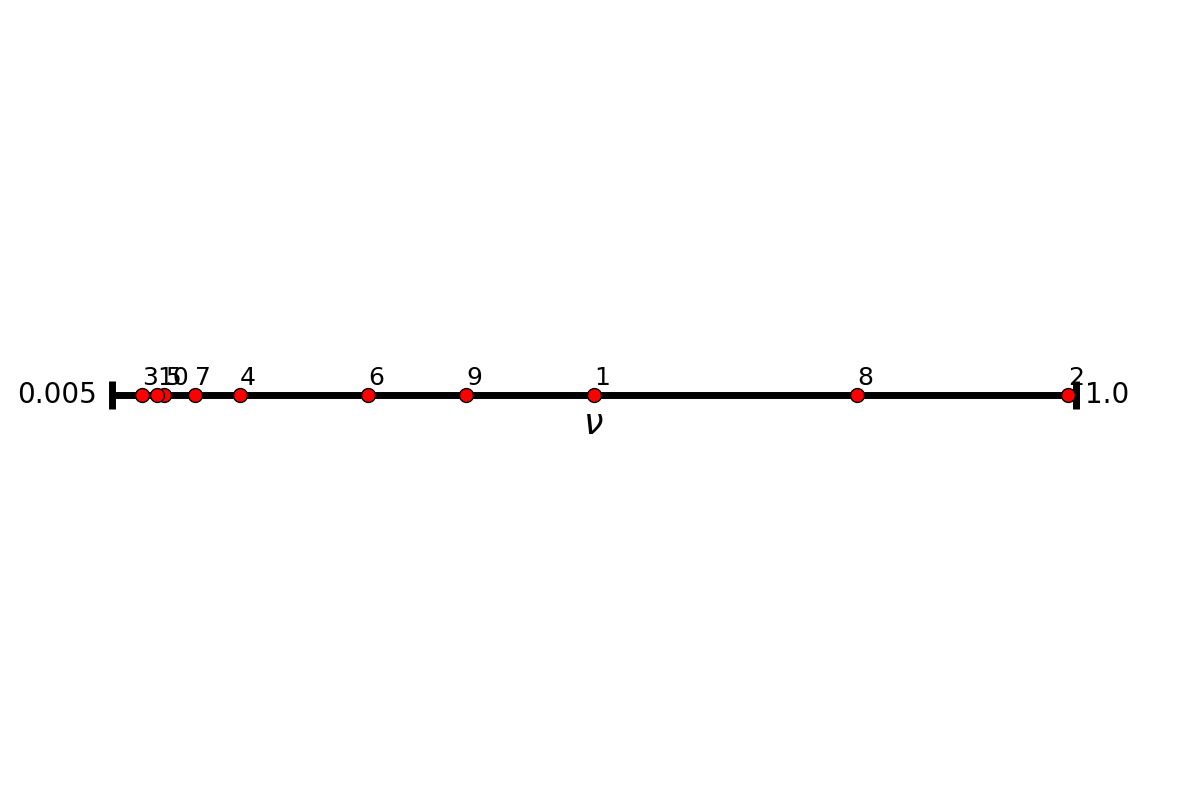

In [13]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(15,10))
xmin = 0.005; xmax = 1
y = 1; height = 0.15

ax.hlines(y, xmin, xmax, colors="k", lw=5)
ax.vlines(xmin, y - height/4, y + height/4, colors="k", lw=5)
ax.vlines(xmax, y - height/4, y + height/4, colors="k", lw=5)

xx = neurons
yy = [y]*len(neurons)

ax.plot(xx, yy, "ko", ms=10, mfc="r")

offsetX=mpl.transforms.ScaledTranslation(.1,  0, fig.dpi_scale_trans)
offsetY=mpl.transforms.ScaledTranslation( 0, .1, fig.dpi_scale_trans)

for i, param in enumerate(neurons):
        if i==14 or i==11:
                ax.text(param-0.025, y, f"{i+1}", ha="left", va="top", transform=ax.transData+offsetX-offsetY, fontsize=18)
        else:
                ax.text(param-0.01, y+0.1, f"{i+1}", ha="left", va="top", transform=ax.transData+offsetX-offsetY, fontsize=18)

ax.text(-0.01, y, "0.005", horizontalalignment="right", 
        verticalalignment="center", fontsize=20)
ax.text(  1.01, y,   "1.0", horizontalalignment="left", 
        verticalalignment="center", fontsize=20)
ax.text((0.005+1.0)/2, y-0.1, r"$\nu$", fontsize=25, 
        horizontalalignment="center")
ax.set_xlim(-0.1,1.1)
ax.set_ylim(0,2)
ax.axis("off")
plt.show()

In [8]:
print({stop})

NameError: name 'stop' is not defined

In [16]:
#### Testing ####
# Recording losses affects the overall time so a seperate function is used
# but they can easily be combined into one.

#b_test = b_train[np.random.choice(len(b_train), test_cases, replace=False)]
b_test = np.loadtxt(data_dir + "/b_test.dat")
pinn_test_soln = np.loadtxt(data_dir+"/pinn_test_soln.dat")

from B_test_lbfgs import gpt_test_lbfgs,gpt_test_loss_lbfgs
print("GPT-PINN Testing Started")
gpt_test_time, gpt_test_soln = gpt_test_lbfgs(b_test, xt_size, IC_size, BC_size, 
IC_u, BC_u, train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, 
train_out_BC, fhat, epochs_gpt_test, lr_gpt, neurons, out_test,Lhat,c_initial)

gpt_test_losses = gpt_test_loss_lbfgs(b_test, xt_size, IC_size, BC_size, IC_u, BC_u, 
train_out, train_out_x, train_out_t, train_out_xx, train_out_IC, train_out_BC, 
fhat, epochs_gpt_test, lr_gpt, neurons,Lhat,c_initial)
print("GPT-PINN Testing Ended\n")

GPT-PINN Testing Started
GPT-PINN Testing Ended



In [20]:
np.savetxt(data_dir+"/sgpt_generation_time.dat",  generation_time[:end])
np.savetxt(data_dir+"/sgpt_max_losses.dat",       loss_list[:end])
np.savetxt(data_dir+"/sgpt_neurons.dat",          neurons)
np.savetxt(data_dir+"/sgpt_total_time.dat",       np.array([total_time]))
np.savetxt(data_dir+"loss_list_sgpt_sparse_grid.dat",loss_list)

np.savetxt(data_dir+"loss_list_sgpt_full_grid.dat",loss_list_full_grid)

np.savetxt(data_dir+"/sgpt_test_losses.dat",  gpt_test_losses)
np.savetxt(data_dir+"/sgpt_test_soln.dat",    gpt_test_soln)
np.savetxt(data_dir+"/sgpt_test_time.dat",    gpt_test_time+total_time)

np.savetxt(data_dir+"/X_umax_idx.dat",  X_umax_idx.cpu().detach())
np.savetxt(data_dir+"/X_rmax_idx.dat",  X_rmax_idx.cpu().detach())
np.savetxt(data_dir+"/xt_resid.dat",         xt_resid.detach().cpu().numpy())
np.savetxt(data_dir+"/xt_test.dat",         xt_resid.detach().cpu().numpy())

params = {"Domain": {"Xi": Xi, "Xf": Xf, "Ti":Ti, "Tf":Tf}, 
          "Data sizes": {"Nc":Nc, "N_test":N_test, "BC_pts":BC_pts, "IC_pts":IC_pts},
          "tol":tol,
          "layers_pinn":layers_pinn,
          "lr_pinn":lr_pinn,
          "epochs_pinn":epochs_pinn,
          "parameter size":len(b_train)+number_of_neurons,
          "number_of_neurons":number_of_neurons,
          "lr_gpt":lr_gpt,
          "epochs_gpt_train":epochs_gpt_train,
          "test_cases":test_cases,
          "epochs_gpt_test":epochs_gpt_test,
          "num_largest_mag":num_largest_mag}

np.save(data_dir+"/params_sgpt.npy", params)

In [18]:
variables = {
    "b_test": b_test,
    "c_initial": c_initial,
    "xt_size": xt_size,
    "IC_size": IC_size,
    "BC_size": BC_size,
    "IC_u": IC_u,
    "BC_u": BC_u,
    "train_out": train_out,
    "train_out_x": train_out_x,
    "train_out_t": train_out_t,
    "train_out_xx": train_out_xx,
    "train_out_IC": train_out_IC,
    "train_out_BC": train_out_BC,
    "fhat": fhat,
    "epochs_gpt_test": epochs_gpt_test,
    "lr_gpt": lr_gpt,
    "neurons": neurons,
    "out_test": out_test,
    "Lhat": Lhat
}
torch.save(variables,data_dir+"/variables_sgpt.npy") 